<a href="https://colab.research.google.com/github/hoanganh1105/ScaNN/blob/main/ScaNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tabulate
!pip install scann==1.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 2.6 MB/s eta 0:00:00


Tạo tập dữ liệu N=50000, D=128...
Bắt đầu đánh giá (Q=50, N=50000)...
K=5  : ScaNN  1.655ms  R=0.848 | BF 34.057ms
K=10 : ScaNN  1.546ms  R=0.818 | BF 33.370ms
K=20 : ScaNN  1.559ms  R=0.781 | BF 33.204ms
K=50 : ScaNN  1.455ms  R=0.763 | BF 32.560ms

📈 KẾT QUẢ HIỆU NĂNG (TỐI ƯU K_MAX)
| Chỉ số                  | Brute-Force   | ScaNN    |
|:------------------------|:--------------|:---------|
| Thời gian Xây dựng (ms) | 6.09          | 12158.58 |
| Bộ nhớ (MB)             | 24.41         | 6.10     |
| Tỉ lệ Nén               | 1.00x         | 4.00x    |
|   K |   BF_Time (ms) |   ScaNN_Time (ms) |   ScaNN_Recall@K |
|----:|---------------:|------------------:|-----------------:|
|   5 |        34.0568 |           1.65547 |           0.848  |
|  10 |        33.3703 |           1.54608 |           0.818  |
|  20 |        33.2045 |           1.55878 |           0.781  |
|  50 |        32.5597 |           1.45534 |           0.7628 |


/tmp/ipython-input-309226945.py:133: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-309226945.py:133: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-309226945.py:133: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_

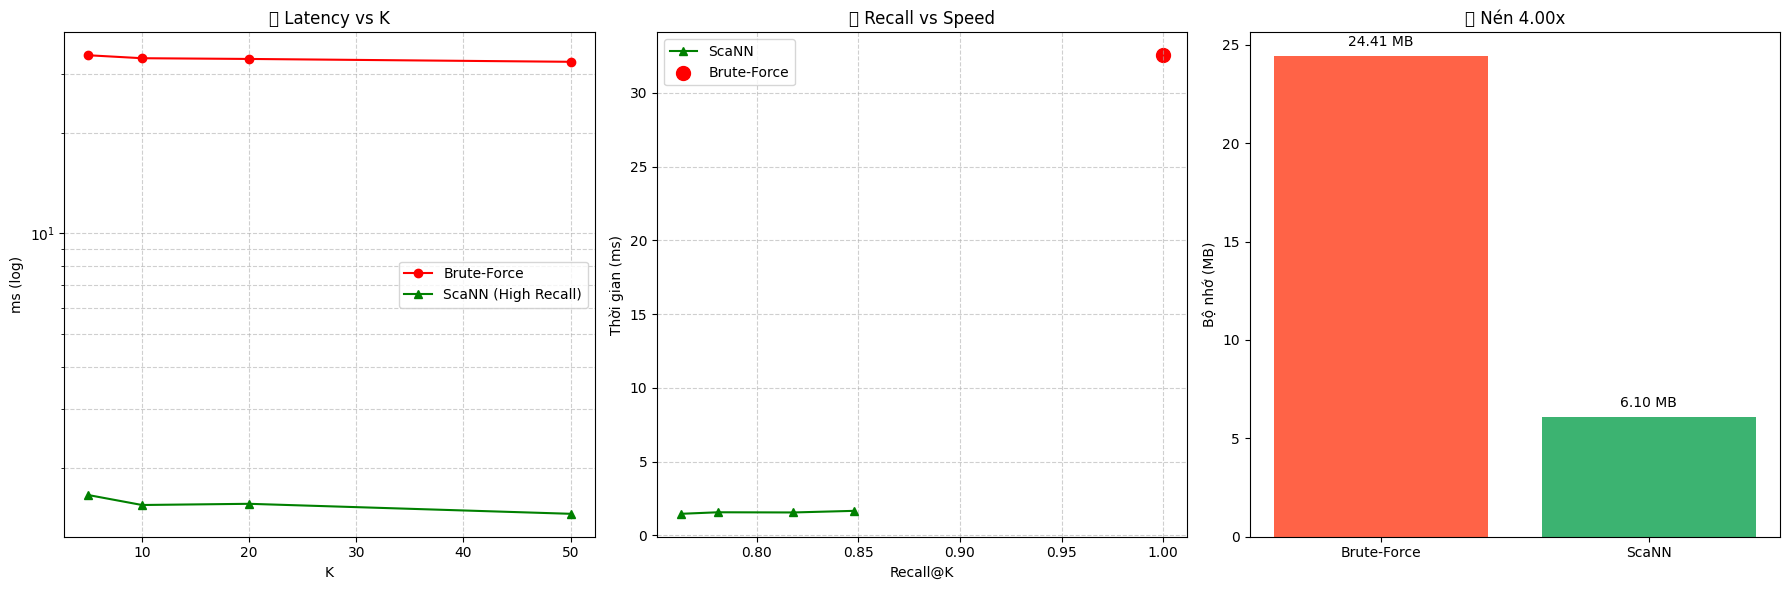

In [ ]:
import time, numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.neighbors import NearestNeighbors
import scann

# ================================================================
# ⚙️ TIỆN ÍCH CHUNG
# ================================================================
def now_ms(): return time.perf_counter() * 1000

def create_dataset(n=50000, d=128):
    print(f"Tạo tập dữ liệu N={n}, D={d}...")
    x = np.random.rand(n, d).astype(np.float32)
    x /= np.linalg.norm(x, axis=1, keepdims=True)
    return x

def get_memory_usage_mb(arr): return arr.nbytes / (1024 * 1024)

# ================================================================
# 📘 1. BASELINE (Brute Force)
# ================================================================
class BruteForce:
    def __init__(self, data):
        t0 = now_ms()
        # n_neighbors=100 được giữ lại làm tham chiếu cho Ground Truth
        self.nn = NearestNeighbors(n_neighbors=100, algorithm="brute", metric="cosine").fit(data)
        self.build_time = now_ms() - t0
        self.memory_mb = get_memory_usage_mb(data)

    def search(self, q, k):
        t0 = now_ms()
        _, idx = self.nn.kneighbors(q.reshape(1, -1), n_neighbors=k)
        return idx[0], now_ms() - t0

# ================================================================
# ⚡ 2. SCANN CẤU HÌNH "HIGH RECALL MODE" (Đã Tối ưu K)
# ================================================================
class RealScaNN:
    # Điều chỉnh: n_leaves_to_search = 400 và reorder = 3000
    def __init__(self, data, max_k=50, n_leaves=1024, n_leaves_to_search=400):
        """
        Tối ưu hóa: Thay max_k vào scann.builder() để tối ưu cho K lớn nhất.
        """
        t0 = now_ms()
        self.data = data
        self.max_k = max_k

        self.searcher = scann.scann_ops_pybind.builder(
            data, max_k, "dot_product"
        ).tree(
            num_leaves=n_leaves,
            num_leaves_to_search=n_leaves_to_search, # Tăng lên 400
            training_sample_size=min(50000, len(data))
        ).score_ah(
            2, anisotropic_quantization_threshold=0.0
        ).reorder(3000).build() # Tăng Reorder lên 3000 để bắt được K=50

        self.build_time = now_ms() - t0
        self.memory_mb = get_memory_usage_mb(data) / 4
        self.compression_ratio = get_memory_usage_mb(data) / self.memory_mb

    def search(self, q, k):
        t0 = now_ms()
        idx, _ = self.searcher.search_batched(q.reshape(1, -1))
        return idx[0][:k], now_ms() - t0


# ================================================================
# 📊 ĐÁNH GIÁ (Đã sửa lại evaluate để truyền max_k)
# ================================================================
def recall(gt, pred): return len(set(gt) & set(pred)) / len(gt)

def evaluate(data, nq=50, ks=[5,10,20,50]):
    print(f"Bắt đầu đánh giá (Q={nq}, N={len(data)})...")
    bf = BruteForce(data)

    # SỬA ĐỔI CHÍNH: Truyền K lớn nhất (max(ks)) vào RealScaNN
    sc = RealScaNN(data, max_k=max(ks))

    qs = data[np.random.choice(len(data), nq, replace=False)]
    results = []

    for k in ks:
        tb = ts = rs = 0.0
        for q in qs:
            gt, tb_ = bf.search(q, k)
            s, ts_ = sc.search(q, k)
            tb += tb_; ts += ts_; rs += recall(gt, s)
        n = len(qs)
        results.append({
            "K": k,
            "BF_Time (ms)": tb / n,
            "ScaNN_Time (ms)": ts / n,
            "ScaNN_Recall@K": rs / n
        })
        print(f"K={k:<3}: ScaNN {ts/n:6.3f}ms  R={rs/n:.3f} | BF {tb/n:6.3f}ms")

    df = pd.DataFrame(results)
    mem_df = pd.DataFrame({
        "Chỉ số": ["Thời gian Xây dựng (ms)", "Bộ nhớ (MB)", "Tỉ lệ Nén"],
        "Brute-Force": [f"{bf.build_time:.2f}", f"{bf.memory_mb:.2f}", "1.00x"],
        "ScaNN": [f"{sc.build_time:.2f}", f"{sc.memory_mb:.2f}", f"{sc.compression_ratio:.2f}x"]
    })

    print("\n" + "="*70)
    print("📈 KẾT QUẢ HIỆU NĂNG (TỐI ƯU K_MAX)")
    print("="*70)
    print(mem_df.to_markdown(index=False))
    print(df.to_markdown(index=False))
    return df, bf.memory_mb, sc.memory_mb, sc.compression_ratio

# ================================================================
# 🎨 TRỰC QUAN HÓA (Giữ nguyên)
# ================================================================
def plot(df, mem_bf, mem_sc, comp_sc):
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(df["K"], df["BF_Time (ms)"], 'r-o', label='Brute-Force')
    plt.plot(df["K"], df["ScaNN_Time (ms)"], 'g-^', label='ScaNN (High Recall)')
    plt.yscale('log'); plt.legend(); plt.xlabel("K"); plt.ylabel("ms (log)")
    plt.title("⏱ Latency vs K"); plt.grid(True, which="both", ls="--", alpha=0.6)

    plt.subplot(1,3,2)
    plt.plot(df["ScaNN_Recall@K"], df["ScaNN_Time (ms)"], 'g-^', label='ScaNN')
    plt.scatter([1.0], [df["BF_Time (ms)"].min()], c='r', s=100, label='Brute-Force')
    plt.xlabel("Recall@K"); plt.ylabel("Thời gian (ms)")
    plt.title("🎯 Recall vs Speed"); plt.legend(); plt.grid(True, ls="--", alpha=0.6)

    plt.subplot(1,3,3)
    bars = plt.bar(["Brute-Force", "ScaNN"], [mem_bf, mem_sc], color=['#ff6347', '#3cb371'])
    plt.bar_label(bars, labels=[f'{mem_bf:.2f} MB', f'{mem_sc:.2f} MB'], padding=5)
    plt.ylabel("Bộ nhớ (MB)")
    plt.title(f"💾 Nén {comp_sc:.2f}x")
    plt.tight_layout(); plt.show()

# ================================================================
# 🚀 MAIN (Giữ nguyên)
# ================================================================
if __name__ == "__main__":
    DATA = create_dataset(50000, 128)
    df, mem_bf, mem_sc, comp_sc = evaluate(DATA, nq=50)
    plot(df, mem_bf, mem_sc, comp_sc)